In [362]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
#import mpld3
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import filter_output_reader as freader
from importlib import reload

import scipy.stats as stats

%matplotlib inline

In [363]:
example_datafile = '../python/example_data.txt'
filter_config = '../cpp/connectivity_8.txt'
output_data = '../cpp/test_output.txt'

In [364]:
reload(freader)
dns_data = freader.read_dns_data(example_datafile)
nodes, conn = freader.read_filter_configuration(filter_config)
filter_result = freader.read_output_data(output_data)

Reading data from:   ../python/example_data.txt
Filter defined in:   connectivity_8.txt


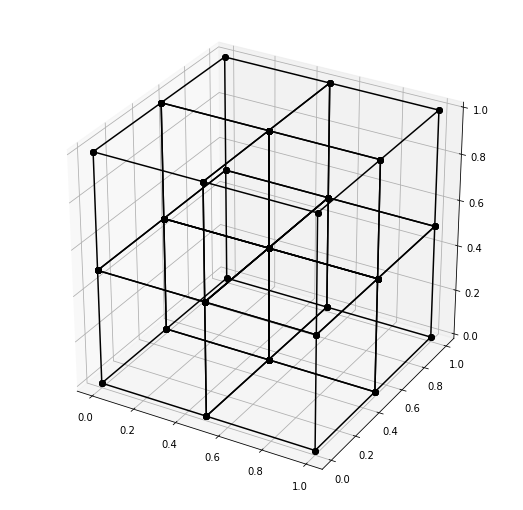

In [365]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
eid = 1
freader.plot_hex(1, nodes, conn, ax)
freader.plot_hex(2, nodes, conn, ax)
freader.plot_hex(3, nodes, conn, ax)
freader.plot_hex(4, nodes, conn, ax)
freader.plot_hex(5, nodes, conn, ax)
freader.plot_hex(6, nodes, conn, ax)
freader.plot_hex(7, nodes, conn, ax)
freader.plot_hex(8, nodes, conn, ax)
plt.savefig('filter_8_initial.pdf')
#freader.plot_filter_cgs(10, 0, filter_result, ax)
#freader.plot_filter_cgs(2, 0, filter_result, ax)

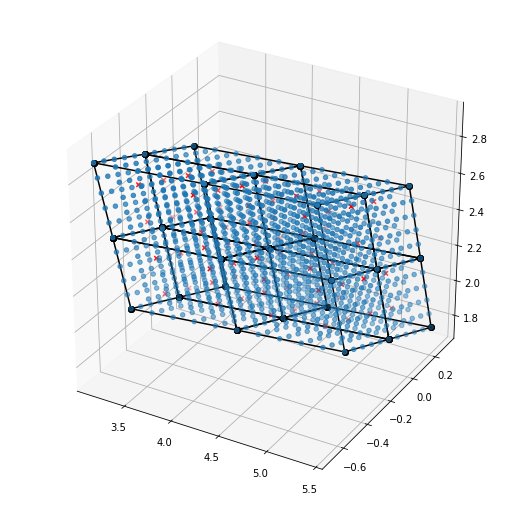

In [366]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

#eid = 10
#t = 0.0
#freader.plot_hex_filter(eid, t, filter_result, ax)
#freader.plot_filter_cgs(eid, t, filter_result, ax)
#eid = 2
#t = 0.0
#freader.plot_hex_filter(eid, t, filter_result, ax)
#freader.plot_filter_cgs(eid, t, filter_result, ax)

t = 1

eid = 1
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 2
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 3
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 4
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 5
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 6
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 7
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
eid = 8
freader.plot_hex_filter(eid, t, filter_result, ax)
freader.plot_filter_cgs(eid, t, filter_result, ax)
ax.scatter(*zip(*dns_data[t]))

#eid = 10
#t = 1.0
##ax.scatter(*zip(*dns_data[t]))
#freader.plot_hex_filter(eid, t, filter_result, ax)
#freader.plot_filter_cgs(eid, t, filter_result, ax)

plt.savefig('filter_8_final.pdf')

In [354]:
tmp = filter_result[1][1].dof_values[0,3:]


D = np.array([[tmp[0], tmp[5], tmp[4]],\
              [tmp[8], tmp[1], tmp[3]],\
              [tmp[7], tmp[6], tmp[2]]])

Csq = np.matmul(D.T, D)
Csq

array([[ 1.0425,  0.13  , -0.085 ],
       [ 0.13  ,  0.24  ,  0.09  ],
       [-0.085 ,  0.09  ,  0.0525]])

In [355]:
np.random.seed(123)
X = np.random.rand(9).reshape((3, 3))
print("X:\n",X)
A = X.dot(X)
print("A:\n",A)

Xs = freader.matsqrt(A)
np.allclose(Xs.dot(Xs), A)

X:
 [[0.69646919 0.28613933 0.22685145]
 [0.55131477 0.71946897 0.42310646]
 [0.9807642  0.68482974 0.4809319 ]]
A:
 [[0.86530995 0.56051022 0.38816255]
 [1.19559529 0.96514433 0.63296392]
 [1.53230958 1.10270543 0.74353916]]


/projects/nathanm/micromorphic/micromorphic_library/overlap_coupling/src/python/filter_output_reader.py:494: RuntimeWarning: invalid value encountered in true_divide
  Jest[:, i] = (Rpi-R)/np.linalg.norm(Xf - Xf*delta)


True

In [356]:
A = X.T.dot(X)
print(A, np.linalg.matrix_rank(A))
Xs = freader.matsqrt(A, mode=2)
np.allclose(Xs.T.dot(Xs), A)

[[1.75091571 1.26759759 0.86294068]
 [1.26759759 1.06850309 0.69867956]
 [0.86294068 0.69867956 0.46177615]] 3


True

In [357]:
A = X.dot(X.T)
print(A, np.linalg.matrix_rank(A))
Xs = freader.matsqrt(A, mode=3)
np.allclose(Xs.dot(Xs.T), A)

[[0.61840663 0.68582444 0.98812887]
 [0.68582444 1.00060265 1.23690893]
 [0.98812887 1.23690893 1.66218568]] 3


True

In [358]:
freader.matsqrt(Csq, mode=2)

array([[ 1.01191649,  0.10050311, -0.09178315],
       [ 0.10050311,  0.44488363,  0.17882304],
       [-0.09178315,  0.17882304,  0.1099917 ]])

In [361]:
filter_result[1][4]

MicromorphicFilterData:
 nodes:
   +4.1750 -0.5000 +2.4250
   +5.1750 -0.4000 +2.4000
   +5.2750 -0.1000 +2.3000
   +4.2750 -0.2000 +2.3250
   +4.1500 -0.6000 +2.8750
   +5.1500 -0.5000 +2.8500
   +5.2500 -0.2000 +2.7500
   +4.2500 -0.3000 +2.7750
 dof values:
   +3.6750 -0.5000 +1.9250 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +4.1750 -0.4000 +1.9000 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +4.2750 -0.6000 +1.8000 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +3.7750 -0.7000 +1.8250 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +3.6500 -0.6000 +1.8750 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +4.1500 -0.5000 +1.8500 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +4.2500 -0.7000 +1.7500 +1.0000 -0.4000 -0.1000 -0.2000 -0.0500 +0.2000 -0.2000 -0.0500 +0.2000
   +3.7500 -0.8000 +1.7750 +1.0000 -0.4000 -0.

In [377]:
u = filter_result[1][4].dof_values[0][:3]
phi_ = filter_result[1][4].dof_values[0][3:]

phi = np.array([[phi_[0], phi_[5], phi_[4]],\
                [phi_[8], phi_[1], phi_[3]],\
                [phi_[7], phi_[6], phi_[2]]])

chi = phi + np.eye(3)

C = freader.matsqrt(chi.T.dot(chi), mode=1)

array([[ 1.00000000e+00,  2.54231309e-16,  3.63042355e-16],
       [ 1.48260255e-16,  1.00000000e+00, -1.60094390e-15],
       [ 3.32316749e-16, -1.64527241e-15,  1.00000000e+00]])